### This notebook calculates the predicted and observed $C^{\kappa g}_{l}$ from *CCL* and *Healpy* (Planck map) respectively, and compares the values.

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt

Binning function from Sukhdeep

In [2]:
import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

### $C^{\kappa g}_{l}$ from theory (CCL)

In [3]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96, \
                      transfer_function="boltzmann_camb")

In [4]:
#params
fs = 18
lmin = 100; lmax = 1500
ell = np.arange(0, lmax, 1)

Define galaxy clustering 

In [5]:
#read in dNdz
dNdzddeg2 = pd.read_csv("dNdz", sep=" ")
dNdzddeg2

,z,dNdzddeg2
0,0.65,309
1,0.75,2269
2,0.85,1923
3,0.95,2094
4,1.05,1441
5,1.15,1353
6,1.25,1337
7,1.35,523
8,1.45,466
9,1.55,329


Text(0.5, 1.0, 'FDR dNdz')

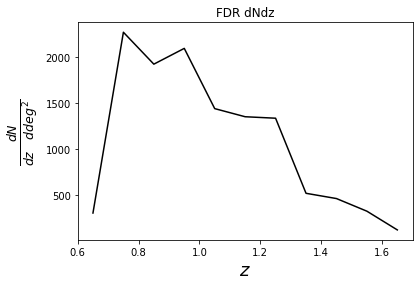

In [6]:
plt.plot(dNdzddeg2['z'], dNdzddeg2['dNdzddeg2'], 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz \quad ddeg^2}$", fontsize = fs)
plt.title("FDR dNdz")

In [7]:
z = dNdzddeg2['z']
area = 14000
dNdz = dNdzddeg2['dNdzddeg2'] * area

Text(0.5, 1.0, 'dNdz from FDR')

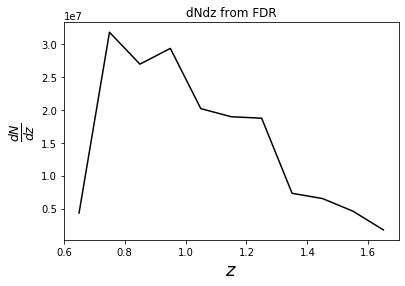

In [8]:
plt.plot(z, dNdz, 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz}$", fontsize = fs)
plt.title("dNdz from FDR")

In [9]:
#set constant bias
b = 1.2*np.ones(len(z))

#Create CCL tracer object for galaxy clustering and CMB
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)

In [10]:
#calculate theoretical Cls
cls_cmb_cross_elg = ccl.angular_cl(cosmo, cmbl, elgl, ell)

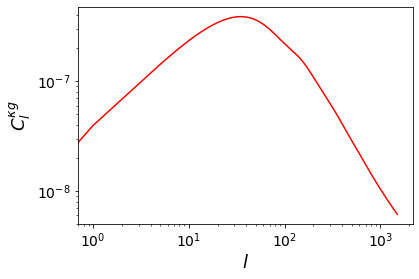

In [11]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{\kappa g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_cmb_cross_elg, 'r-')
plt.show()

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


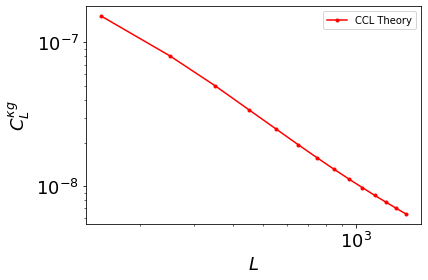

In [12]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cls_cmb_cross_elg, ELL)

fltr = (tmp[0] > 100)
ELL_th = tmp[0][fltr]
cLkg_th = tmp[1][fltr]

plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkg_th, 'r.-', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.show()

### $C^{\kappa g}_{l}$ from DESI Legacy Surveys DR8 and Planck 

Read in ELG catalogue

In [13]:
#load elg and random file
elgCat = np.load("elg_delta1024.npy")
randomCat = np.load("elg_ran1024.npy")

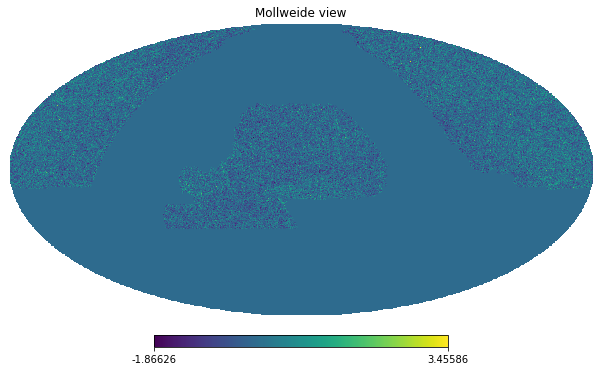

In [14]:
#view ELG catalogue
hp.mollview(elgCat)

Rotate ELG catalogue from Equatorial Coordinates to Galactic Coordinates

In [15]:
#define rotator class from Eq. Coord. to Gal. Coord
r = hp.Rotator(coord=['C','G'])

LMAX = 1500
elgCat_galactic = r.rotate_map_alms(elgCat, lmax = LMAX)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


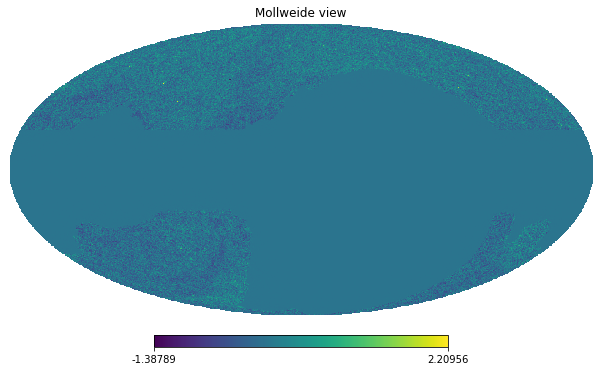

In [16]:
hp.mollview(elgCat_galactic)

In [17]:
almELG = hp.map2alm(elgCat_galactic, lmax=4096)

Read in CMB lensing catalogue

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


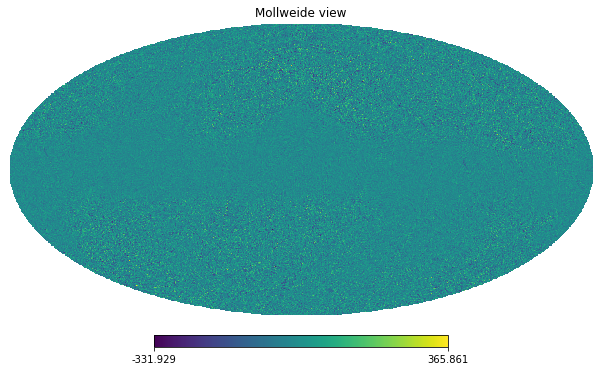

In [18]:
almLensing_planck = hp.fitsfunc.read_alm("lensing/MV/dat_klm.fits")
lensingMap_planck = hp.sphtfunc.alm2map(almLensing_planck, \
                    nside = 1024, sigma=np.deg2rad(0.0)) #nside value comes from https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps
hp.mollview(lensingMap_planck)

Cross-correlating in $a_{lm}$ space

In [19]:
cl_cross_observed = hp.alm2cl(almELG, almLensing_planck)

In [20]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cl_cross_observed[:1500], ELL)

fltr = (tmp[0] > 100)
ELL_obs = tmp[0][fltr]
cLkg_obs = tmp[1][fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


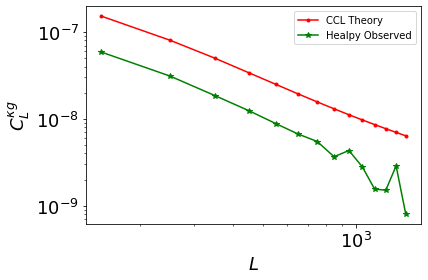

In [21]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkg_th, 'r.-', label = 'CCL Theory')
plt.plot(ELL_obs, cLkg_obs, 'g*-', label = "Healpy Observed")
plt.legend(loc = 'best')
plt.show()

$f_{sky}$ correction

In [22]:
randomCat_galactic = r.rotate_map_pixel(randomCat)

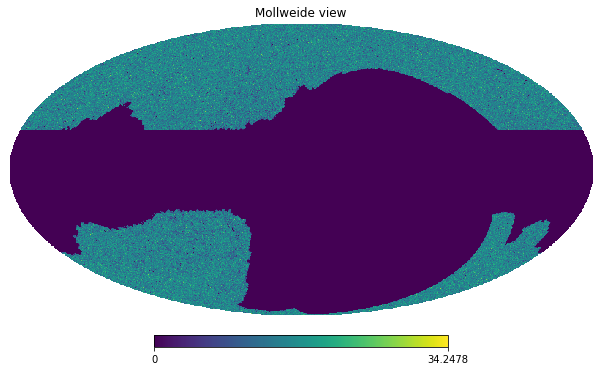

In [23]:
hp.mollview(randomCat_galactic)

In [24]:
#check ELG fsky for consistency
npix_bad = hp.ud_grade(randomCat_galactic, 2048)[hp.ud_grade(randomCat_galactic, 2048) == 0].size
npix = hp.ud_grade(randomCat_galactic, 2048).size

print(f"ELG fsky = {1 - npix_bad/npix}")

ELG fsky = 0.3854801654815674


In [25]:
#Extract CMB mask
lensingMask_planck = hp.fitsfunc.read_map("lensing/mask.fits")
mask_planck = lensingMask_planck
mask_planck.shape

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


(50331648,)

In [26]:
#Logical combine two masks to get overlaps
mask_combined = np.logical_and(hp.ud_grade(randomCat_galactic, 2048), lensingMask_planck)

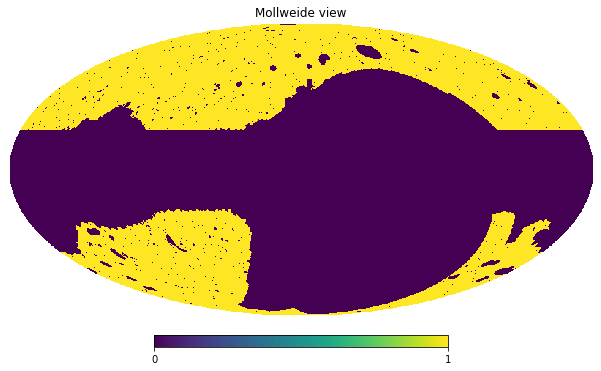

In [30]:
hp.mollview(mask_combined)

In [27]:
fsky_elg_cross_cmb = mask_combined.sum()/mask_combined.size
fsky_elg_cross_cmb

0.3696065942446391

$f_{sky}$ corrected cross-correlation

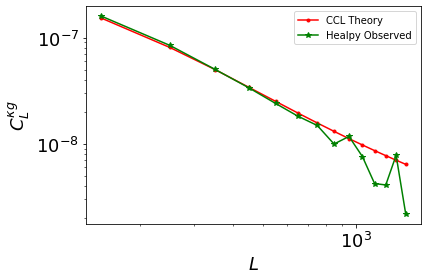

In [28]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa g}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkg_th, 'r.-', label = 'CCL Theory')
plt.plot(ELL_obs, cLkg_obs/fsky_elg_cross_cmb, 'g*-', label = "Healpy Observed")
plt.legend(loc = 'best')
plt.savefig("results/cLkg.pdf")
plt.show()

In [29]:
np.mean((cLkg_obs/fsky_elg_cross_cmb)/cLkg_th)

0.855585215020626

In [66]:
np.mean(cLkg_obs/cLkg_th)

0.3162299374098408

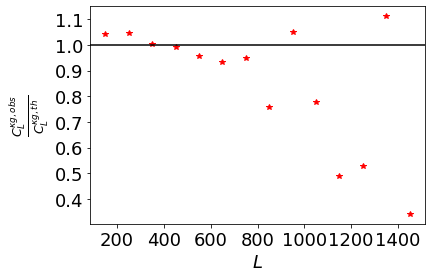

In [67]:
plt.plot(ELL_obs, (cLkg_obs/fsky_elg_cross_cmb)/cLkg_th, "r*")
plt.xlabel(r'$L$',fontsize=fs)
plt.ylabel(r'$\frac{C^{\kappa g, obs}_{L}}{C^{\kappa g, th}_{L}}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.axhline(1, c = "k")

S/N calculation

In [68]:
def cLkg_var(l, cLkg, cLkk, nLkk, cLgg, nLgg, fsky = fsky_elg_cross_cmb):
    """Returns variance of c_L^{\kappa g}"""
    delta_cLkg2 = 1/((2 * l + 1) * fsky) * (cLkg**2 + (cLkk + nLkk) * (cLgg + nLgg))

In [69]:
#from clkk notebook
cLkk_denoised_defsky = np.array([1.09570780e-07, 7.77439724e-08, 6.49371566e-08, 4.91351904e-08,
       3.58260274e-08, 2.44205598e-08, 2.14509571e-08, 2.47131622e-08,
       3.13950750e-08, 1.73765542e-08, 1.25235619e-08, 2.81682990e-08,
       2.03681766e-08, 2.60788196e-08])

In [70]:
#from cLgg notebook
cLgg_denoised_defsky = np.array([1.18024328e-06, 5.65849441e-07, 3.58868174e-07, 2.60370319e-07,
       1.94762589e-07, 1.67327792e-07, 1.41749327e-07, 1.20810004e-07,
       1.09567333e-07, 1.01545486e-07, 9.51113727e-08, 8.70568352e-08,
       8.41040776e-08, 7.96987179e-08])

Calculate RCC

\begin{equation}
\text{RCC} = \frac{C^{\kappa g}_{L}}{\sqrt{C^{g g}_{L} C^{\kappa \kappa}_{L}}}
\end{equation}

In [88]:
rcc = (cLkg_obs/fsky_elg_cross_cmb)/np.sqrt((cLgg_denoised_defsky) * (cLkk_denoised_defsky))

Text(0, 0.5, 'RCC')

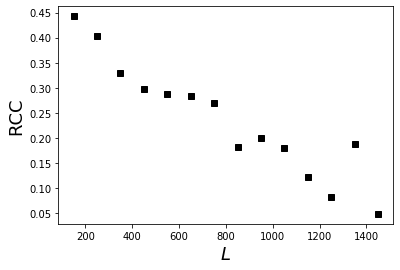

In [89]:
plt.plot(ELL_obs, rcc, "ks")
plt.xlabel("$L$", fontsize = fs)
plt.ylabel("RCC", fontsize = fs)
#plt.axhline(1)

Calculate RCC from theory

In [85]:
cLgg_th = np.array([1.34690050e-06, 7.00283409e-07, 4.31253640e-07, 2.94031774e-07,
       2.16749791e-07, 1.68526039e-07, 1.36665876e-07, 1.14365237e-07,
       9.80668606e-08, 8.57666829e-08, 7.61771871e-08, 6.85233561e-08,
       6.22765633e-08, 5.70846342e-08])

cLkk_th = np.array([1.19256345e-07, 7.38599927e-08, 5.05467125e-08, 3.66634054e-08,
       2.76719092e-08, 2.16574013e-08, 1.74969418e-08, 1.44786753e-08,
       1.21917767e-08, 1.04140193e-08, 9.01282088e-09, 7.89329716e-09,
       6.98365101e-09, 6.23169399e-09])

In [86]:
rcc_th = cLkg_th/np.sqrt(cLgg_th * cLkk_th)

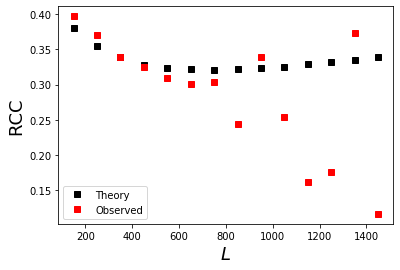

In [87]:
plt.plot(ELL_obs, rcc_th, "ks", label = "Theory")
plt.plot(ELL_obs, rcc, "rs", label = "Observed")
plt.xlabel("$L$", fontsize = fs)
plt.ylabel("RCC", fontsize = fs)
plt.legend(loc = 'best')
#plt.axhline(1)